### Surface model example

This example shows how to fit the model taking margin of victory and surface into account.

There is a set of convenient functions in `jax_elo.models.correlated_skills_model` which we will use for this.

In [47]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
from jax_elo.models.correlated_skills_model import fit, calculate_ratings, predict, get_player_skill_history
from jax_elo.utils.data import get_data


In [48]:
# Change this to where your data is located.
# This uses Jeff Sackmann's dataset, which is available here:
# https://github.com/JeffSackmann/tennis_atp
data = get_data('/home/martin/data/tennis_atp/')

In [54]:
to_use = data[data['tourney_date'].dt.year >= 1960]
to_use = to_use[to_use['surface'] != 'Carpet']
to_use = to_use.dropna(subset=['surface'])

In [56]:
to_use['surface'].value_counts()

Hard     63940
Clay     56878
Grass    19255
Name: surface, dtype: int64

In [57]:
# Compute the margin on the % of service points won
#margins = to_use['spw_winner'] - to_use['spw_loser']

In [58]:
# Fit the model -- this might take a few minutes (but not more than that)
#params, opt_info = fit(to_use['winner_name'], to_use['loser_name'], to_use['surface'].values, 
#                       margins=margins.values, verbose=True)
#np.savez('theta_2010_onwards', **params.theta)

In [59]:
from jax_elo.core import EloParams
params = np.load('theta_2010_onwards.npz')
params = EloParams(theta=dict(params))

In [60]:
# We can now calculate the rating history:
history, final_rating_dict, mark_names = calculate_ratings(params, to_use['winner_name'], to_use['loser_name'],
                                                           to_use['surface'].values)

In [61]:
# Here's an example entry:
history[-1]

{'winner': 'Aslan Karatsev',
 'loser': 'Lloyd Harris',
 'winner_prior_mean': {'Clay': 1701.1176792031363,
  'Grass': 1766.5298499975245,
  'Hard': 1760.649910192312},
 'loser_prior_mean': {'Clay': 1696.2169141342845,
  'Grass': 1743.3732388209169,
  'Hard': 1744.997920686841},
 'winner_prior_prob': 0.5207272825882019,
 'cur_mark': 'Hard'}

In [62]:
# We can predict matches on a particular surface
predict(final_rating_dict, params, 'Roger Federer', 'Tennys Sandgren', 'Hard', mark_names)

0.9414441738564802

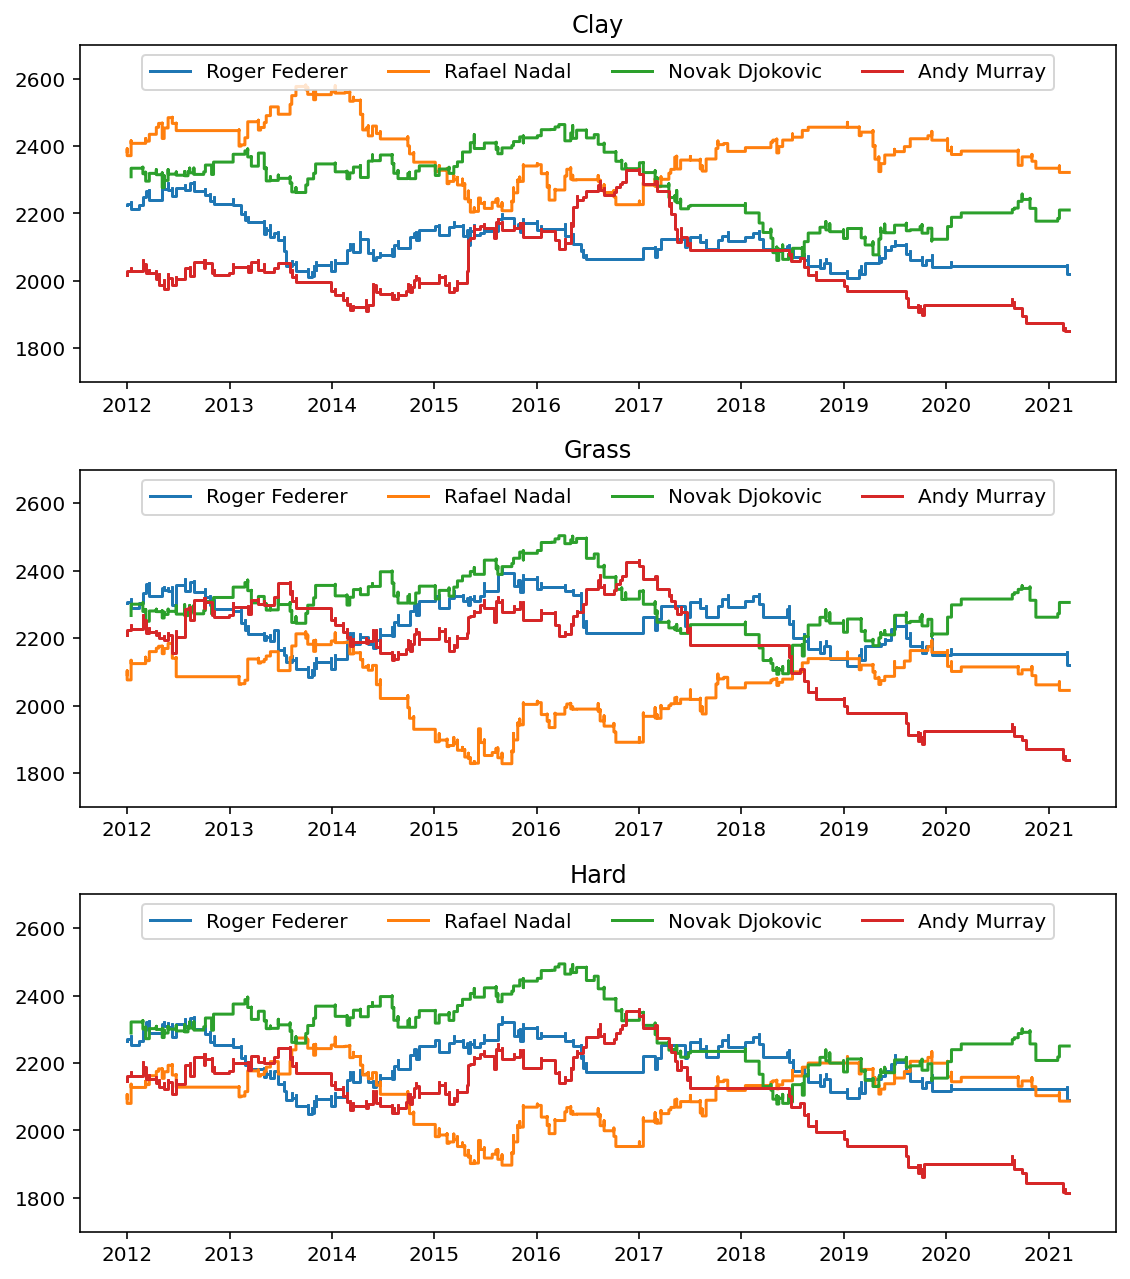

In [63]:
# We can plot the ratings over time:
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(len(mark_names), 1)

start_year = 2012

for cur_player in ['Roger Federer', 'Rafael Nadal', 'Novak Djokovic', 'Andy Murray']:

    cur_history = get_player_skill_history(history, final_rating_dict, to_use['tourney_date'].values, cur_player)
    cur_history = cur_history[cur_history.index >= f'{start_year}-01-01']
    
    for cur_surface, cur_ax in zip(mark_names, ax.reshape(-1)):
        cur_ax.step(cur_history.index, cur_history[cur_surface].values, label=cur_player)
        cur_ax.legend(ncol=4, loc='upper center')
        cur_ax.set_title(cur_surface)
        cur_ax.set_ylim(1700, 2700)

f.set_size_inches(8, 9)
f.tight_layout()


In [64]:
# We can look at the marginal standard deviations on each surface
import numpy as np
import pandas as pd

prior_sd = pd.Series(np.sqrt(np.diag(params.theta['cov_mat'])), mark_names)
print(prior_sd)

Clay      92.236628
Grass    103.626948
Hard      83.079810
dtype: float64


In [65]:
# Finally, we can look at the correlation matrix between surface results
def covar_to_corr(covar_mat):
    # Turns a covariance matrix into a correlation matrix

    marg_var = np.diag(covar_mat)
    marg_sd = np.sqrt(marg_var)
    inv_marg = np.diag(1. / marg_sd)

    return np.dot(np.dot(inv_marg, covar_mat), inv_marg)

corr_mat = covar_to_corr(params.theta['cov_mat'])

In [66]:
pd.DataFrame(corr_mat, index=mark_names, columns=mark_names).round(3)

,Clay,Grass,Hard
Clay,1.000,0.437,0.695
Grass,0.437,1.000,0.820
Hard,0.695,0.820,1.000


In [67]:
win_probs = np.stack([x['winner_prior_prob'] for x in history])
np.mean(np.log(win_probs))

-0.588606065506239

In [68]:
# Compare with Elo:
from jax_elo.utils.elo import optimise_static_k, compute_elo_ratings

In [69]:
k, _ = optimise_static_k(to_use['winner_name'].values, to_use['loser_name'].values)

In [70]:
elo_results = pd.DataFrame(compute_elo_ratings(to_use['winner_name'].values, to_use['loser_name'].values, lambda _: k))

In [71]:
# Standard Elo has a lower log likelihood:
np.mean(np.log(elo_results['winner_prob']))

-0.5967535453549615

In [72]:
# Accuracy
np.mean(elo_results['winner_prob'] > 0.5)

0.6746910539504402